In [ ]:
%pip install pandas==1.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.7 MB 4.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np
from datetime import datetime
import random
import bisect

In [ ]:
GiB32 = 32 * 1024 ** 3 # bytes in 32 GiB sector

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/df_supply_simulation_for_JP_Shyam_261122.csv")[2:]
dfu = df[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'date']]
dfu.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[2,'cum_network_reward']
dfu.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

Mounted at /content/drive


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/df_supply_simulation_for_JP_Shyam_251122.csv")[2:]
dfu2 = df2[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'date']]
dfu2.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[2,'cum_network_reward']
dfu2.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu2.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu2.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu2.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'network_QAP']))
dfu2.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

pledge_compute_df = dfu2[(dfu2['date']> '2022-07-01') & (dfu2['date']< '2022-11-01')] 
PLEDGE_ZERO_DAY = pledge_compute_df['day_locked_pledge_per32GiBQAP'].mean()
PLEDGE_ZERO_DAY 

0.238057284161032

In [ ]:
class ArrayWrapperObj:
    def __init__(self, arr):
        self.arr = arr
    def get(self):
        return self.arr

In [ ]:
dfv = pd.read_pickle("/content/drive/MyDrive/cil_mcmc_df_roi.pkl")
#  dfv = dfv.groupby('date').mean()
# dfv = dfv.groupby('date').median()

In [ ]:
def get_df_summary(df)->pd.DataFrame:
    df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

In [ ]:
dfv_summary = get_df_summary(dfv)
dfv = dfv_summary[(dfv_summary['quantile'] == 0.5)]

<ipython-input-7-b1ff474fdfc2>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])


In [ ]:
dfv.columns

Index(['date', 'quantile', 'days', 'circ_supply', 'network_gas_burn',
       'day_locked_pledge', 'day_renewed_pledge', 'network_locked_pledge',
       'network_locked', 'network_locked_reward', 'disbursed_reserve',
       'total_vest', 'network_RBP', 'network_QAP', 'day_onboarded_power_QAP',
       'day_renewed_power_QAP', 'cum_simple_reward', 'network_baseline',
       'capped_power', 'cum_capped_power', 'network_time',
       'cum_baseline_reward', 'cum_network_reward', 'day_network_reward',
       'iter', 'day_pledge_per_QAP', 'day_rewards_per_sector',
       '1y_return_per_sector', '1y_sector_roi'],
      dtype='object')

In [ ]:
dfu = dfv[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'day_pledge_per_QAP', 'date']][1:1830]
dfu = dfu.reset_index()
dfu.loc[:,'zeroed_cum_network_reward'] = dfu.loc[:,'cum_network_reward']  - dfu.loc[1,'cum_network_reward']
dfu.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (dfu.loc[:,'zeroed_cum_network_reward'] / (dfu.loc[:,'network_QAP']))
dfu.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * dfu.loc[:,'day_network_reward'] / (dfu.loc[:,'network_QAP'])
dfu.loc[:,'day_penalty_per32GiBQAP'] = 90 * dfu.loc[:,'day_network_reward_per32GiBQAP']
dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = (dfu.loc[:,'day_pledge_per_QAP'])
# dfu.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (dfu.loc[:,'day_locked_pledge'] / (dfu.loc[:,'day_onboarded_power_QAP']+dfu.loc[:,'day_renewed_power_QAP']))

In [ ]:
# df_temp = pd.read_csv("/content/drive/MyDrive/df_supply_simulation_for_JP_Shyam_261122.csv")[2:]
# df_temp_u = df_temp[['day_network_reward','day_locked_pledge','cum_network_reward', 'network_QAP', 'day_onboarded_power_QAP', 'day_renewed_power_QAP', 'date']]
# df_temp_u.loc[:,'zeroed_cum_network_reward'] = df_temp_u.loc[:,'cum_network_reward']  - df_temp_u.loc[2,'cum_network_reward']
# df_temp_u.loc[:,'zeroed_cum_network_reward_per32GiBQAP'] = GiB32 * (df_temp_u.loc[:,'zeroed_cum_network_reward'] / (df_temp_u.loc[:,'network_QAP']))
# df_temp_u.loc[:,'day_network_reward_per32GiBQAP'] =  GiB32 * df_temp_u.loc[:,'day_network_reward'] / (df_temp_u.loc[:,'network_QAP'])
# df_temp_u.loc[:,'day_penalty_per32GiBQAP'] = 90 * df_temp_u.loc[:,'day_network_reward_per32GiBQAP']
# df_temp_u.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (df_temp_u.loc[:,'day_locked_pledge'] / (df_temp_u.loc[:,'network_QAP']))
# df_temp_u.loc[:,'day_locked_pledge_per32GiBQAP'] = GiB32 * (df_temp_u.loc[:,'day_locked_pledge'] / (df_temp_u.loc[:,'day_onboarded_power_QAP']+df_temp_u.loc[:,'day_renewed_power_QAP']))

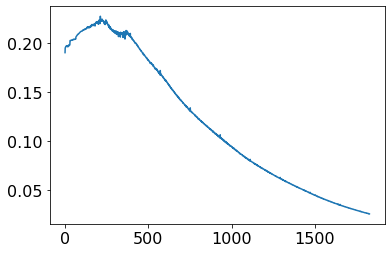

In [ ]:
dfu['day_locked_pledge_per32GiBQAP'].plot()

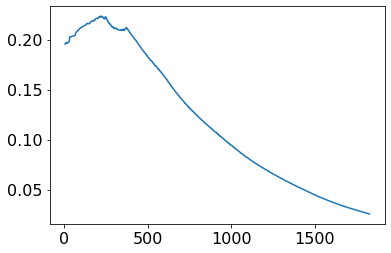

In [ ]:
from scipy.signal import savgol_filter
# dfu['smoothed_day_locked_pledge_per32GiBQAP'] = savgol_filter(dfu['day_locked_pledge_per32GiBQAP'], 51, 3)
# dfu['smoothed_day_locked_pledge_per32GiBQAP'] = dfu['day_locked_pledge_per32GiBQAP'].rolling(30).median()
dfu['smoothed_day_locked_pledge_per32GiBQAP'] = dfu['day_locked_pledge_per32GiBQAP'].rolling(7).median()
dfu['smoothed_day_locked_pledge_per32GiBQAP'].plot()

## Constraints

### Block Space Constraints

In [ ]:
def p_gas(lambda_gas:float,reseal_day:int):
    normal_gas = (365 * dfu.loc[reseal_day,'day_network_reward_per32GiBQAP'] / 10)
    gas_penalty = normal_gas * (1 + 365 * lambda_gas / reseal_day)
    return gas_penalty

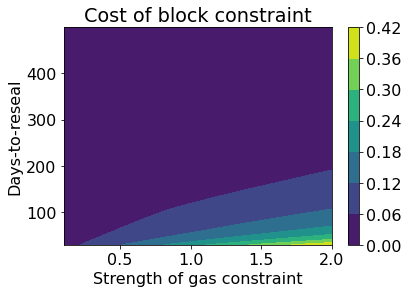

In [ ]:
lambda_gaslist, reseal_daylist = np.linspace(0.1,2,10), range(30,500)
l1, r = np.meshgrid(lambda_gaslist, reseal_daylist)
Z_gas = [[p_gas(lambda1, reseal) for lambda1 in lambda_gaslist] for reseal in reseal_daylist]

fig,ax = plt.subplots(1,1)
cp = ax.contourf(l1, r, Z_gas)
fig.colorbar(cp)
ax.set_title('Cost of block constraint')
ax.set_ylabel('Days-to-reseal')
ax.set_xlabel('Strength of gas constraint')
plt.show()

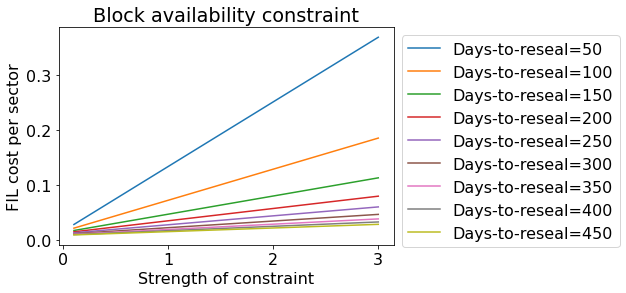

In [ ]:
for reseal_day_i in range(50,500,50):
    plt.plot(np.linspace(0.1,3,25),
             [p_gas(lambda_i,reseal_day=reseal_day_i) for lambda_i in np.linspace(0.1,3,25)],
             label=f'Days-to-reseal={reseal_day_i}')
plt.xlabel("Strength of constraint")
plt.ylabel("FIL cost per sector")
plt.title('Block availability constraint')
plt.legend(bbox_to_anchor=(1, 1));

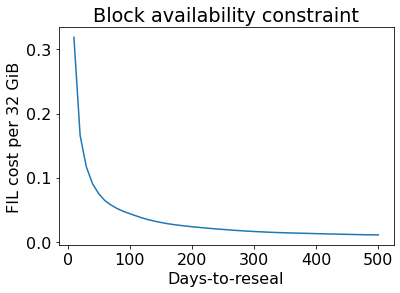

In [ ]:
# For strength coefficient 0.5,
# this gives the following curve:
plt.plot(np.linspace(10,500),
         [p_gas(lambda_gas=0.5,reseal_day=reseal_day_i) for reseal_day_i in np.linspace(10,500)])
plt.xlabel("Days-to-reseal")
plt.title('Block availability constraint')
plt.ylabel("FIL cost per 32 GiB");

### Machine Availability Constraints

In [ ]:
def fraction_penalised(lambda_machine:float,reseal_day:int):
    return np.exp(-reseal_day / (lambda_machine * 365))
    
def p_machine(lambda_machine:float,reseal_day:int):
    penalty = dfu.loc[reseal_day,'day_penalty_per32GiBQAP']
    time_distribution = fraction_penalised(lambda_machine,reseal_day)
    machine_penalty = penalty * time_distribution
    return machine_penalty

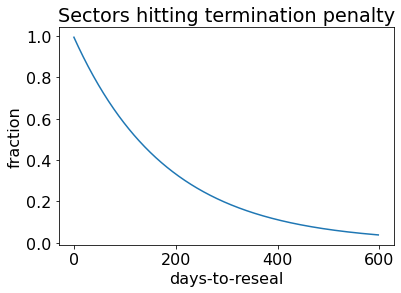

In [ ]:
plt.plot([fraction_penalised(0.5,day_i) for day_i in range(1,600)]);
plt.title('Sectors hitting termination penalty')
plt.xlabel('days-to-reseal')
plt.ylabel('fraction');
plt.show()

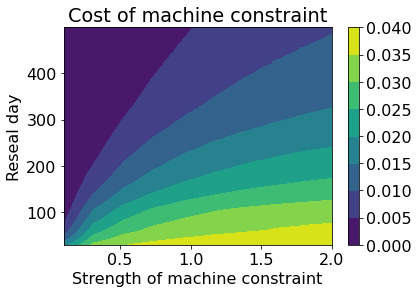

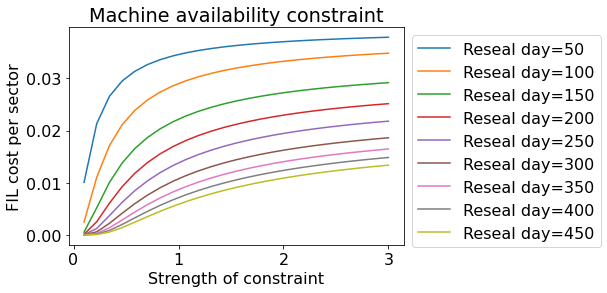

In [ ]:
lambda_machinelist = np.linspace(0.1,2,10)
l2, r = np.meshgrid(lambda_machinelist, reseal_daylist)
Z_machine = [[p_machine(lambda1, reseal) for lambda1 in lambda_machinelist] for reseal in reseal_daylist]

fig,ax = plt.subplots(1,1)
cp = ax.contourf(l2, r, Z_machine)
fig.colorbar(cp)
ax.set_title('Cost of machine constraint')
ax.set_ylabel('Reseal day')
ax.set_xlabel('Strength of machine constraint')
plt.show()

for reseal_day_i in range(50,500,50):
    plt.plot(np.linspace(0.1,3,25),
             [p_machine(lambda_i,reseal_day=reseal_day_i) for lambda_i in np.linspace(0.1,3,25)],
             label=f'Reseal day={reseal_day_i}')
plt.legend(bbox_to_anchor=(1, 1));
plt.xlabel("Strength of constraint")
plt.ylabel("FIL cost per sector")
plt.title('Machine availability constraint');

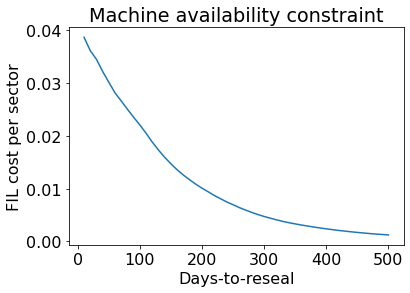

In [ ]:
plt.plot(np.linspace(10,500),
         [p_machine(lambda_machine=0.5,reseal_day=reseal_day_i) for reseal_day_i in np.linspace(10,500)])
plt.xlabel('Days-to-reseal')
plt.title("Machine availability constraint")
plt.ylabel("FIL cost per sector");

## Utilities of Different Pathways

### Reseal

In [ ]:
# utility of resealing
def u1_reseal(tau:int,T:int,lambda_gas=0.5,lambda_machine=0.5,debug=False)->float:
    '''
    -----------------------
    tau : int
        time until reseal required
    T : int 
        profit horizon
    lambda_gas : float:
        Strength of block space constraint
    lambda_machine : float 
        Strength of sealing machine availabilty
    
    '''
    if T>tau:
      reseal_day = np.round(tau * 0.8) # typical reseal is 80% of max
    else:
      reseal_day = np.round(T * 0.8) 
      
    cum_reward = dfu.loc[T,'zeroed_cum_network_reward_per32GiBQAP']
    pledge = dfu.loc[reseal_day,'smoothed_day_locked_pledge_per32GiBQAP']
    pledge_return = PLEDGE_ZERO_DAY
    extra_pledge = max(pledge - pledge_return,0)
    gas = p_gas(lambda_gas,reseal_day)
    machine = p_machine(lambda_machine,reseal_day)
    utility = cum_reward - extra_pledge - gas - machine
    
    if debug == True:
        print(np.round([utility, cum_reward, pledge,pledge_return, extra_pledge, gas, machine],2))
    else:
        return utility

# Sanity check some numbers
u1_reseal(150,500,debug=True)
u1_reseal(10,500,debug=True)
u1_reseal(150,50,debug=True)
u1_reseal(10,50,debug=True)

[0.11 0.16 0.21 0.24 0.   0.04 0.02]
[-0.27  0.16  0.2   0.24  0.    0.4   0.04]
[-0.1   0.02  0.2   0.24  0.    0.09  0.03]
[-0.41  0.02  0.2   0.24  0.    0.4   0.04]


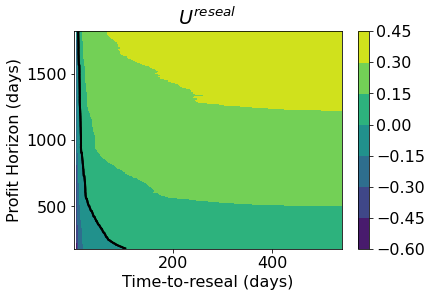

In [ ]:
taulist, tlist = np.arange(2,540), np.arange(180,1825)
Tau, T = np.meshgrid(taulist, tlist)
Z1 = [[u1_reseal(tau,T,0.5,0.5) for tau in taulist] for T in tlist]

fig,ax = plt.subplots(1,1)
cp = ax.contourf(Tau, T, Z1)
cp0 = plt.contour(Tau, T, Z1,levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
fig.colorbar(cp) 
ax.set_title('${U^{reseal}}$')
ax.set_ylabel('Profit Horizon (days)')
ax.set_xlabel('Time-to-reseal (days)')
plt.show()

### No Reseal

In [ ]:
# utility of not resealing
def u2_noreseal(tau:int,T:int,debug=False)->float:
    ''' 
    '''
    reward_horizon = min(tau, T)
    reward = dfu.loc[reward_horizon,'zeroed_cum_network_reward_per32GiBQAP'] 
    penalty = dfu.loc[tau,'day_penalty_per32GiBQAP'] if tau<T else 0
    utility = reward - penalty
    
    if debug == True:
        print(np.round([utility, reward, penalty, reward_horizon],4))
    else:
        return utility

 
# Sanity checksome numbers
u2_noreseal(150,500,debug=True)
u2_noreseal(10,500,debug=True)
u2_noreseal(110,100,debug=True)
u2_noreseal(90,100,debug=True)

[2.87e-02 6.21e-02 3.34e-02 1.50e+02]
[-3.68e-02  4.10e-03  4.09e-02  1.00e+01]
[4.28e-02 4.28e-02 0.00e+00 1.00e+02]
[3.00e-04 3.87e-02 3.85e-02 9.00e+01]


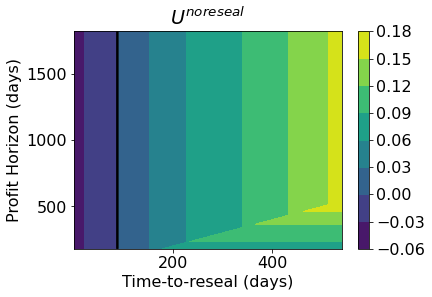

In [ ]:
Z2 = [[u2_noreseal(tau,T) for tau in taulist] for T in tlist]

fig,ax = plt.subplots(1,1)
cp = ax.contourf(Tau, T, Z2)
cp0 = plt.contour(Tau, T, Z2,levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('$U^{no reseal}}$')
ax.set_ylabel('Profit Horizon (days)')
ax.set_xlabel('Time-to-reseal (days)')
plt.show()

### Relative Utility

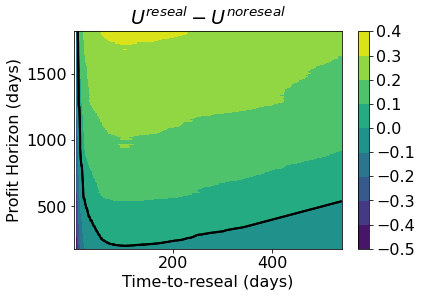

In [ ]:
# relative advantange of resealing over not
Z3 = (np.array(Z1)-np.array(Z2))
fig,ax = plt.subplots(1,1)
cp = ax.contourf(Tau, T, Z3)
cp0 = plt.contour(Tau, T, Z3,levels = [-0.0001,0],
                 colors=('k',),linestyles=('-',),linewidths=(2,))

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('${U^{reseal} - U^{no reseal}}$')
ax.set_ylabel('Profit Horizon (days)')
ax.set_xlabel('Time-to-reseal (days)')
plt.show()

In [ ]:
p = cp0.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]

In [ ]:
rel_utility = {}
for A, B in zip(x, y):
    rel_utility[A] = B

def rel_utility_mapping(a):
  res = min(rel_utility.keys(), key = lambda key: abs(key-a))
  return rel_utility[res]

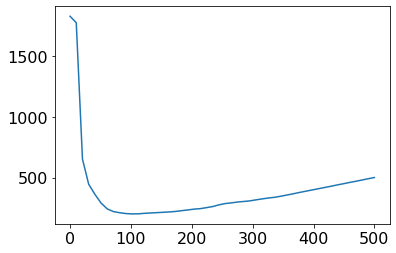

In [ ]:
plt.plot(np.linspace(0,500), [rel_utility_mapping(reseal_day_i) for reseal_day_i in np.linspace(0,500)])

## Tying with reseal distributions

In [ ]:
def time_to_reseal(ProofRefreshWindow, number_of_refreshes, beta_value, MaxProofDuration = 540):
  ProofExpiry = (number_of_refreshes + 1)*MaxProofDuration - (number_of_refreshes)*ProofRefreshWindow
  ProofRefreshStart = (number_of_refreshes + 1)*MaxProofDuration - (number_of_refreshes + 1)*ProofRefreshWindow

  if number_of_refreshes == 0:
    ProofLastRefreshed = 0
  else:
    lower_bound = (number_of_refreshes)*MaxProofDuration - (number_of_refreshes)*ProofRefreshWindow
    upper_bound = (number_of_refreshes)*MaxProofDuration - (number_of_refreshes - 1)*ProofRefreshWindow

    X = np.random.beta(beta_value,1)
    ProofLastRefreshed = (ProofRefreshWindow)*X + lower_bound

  if number_of_refreshes == 5:
    BugDiscovered = np.random.uniform(low = ProofLastRefreshed, high = 1825)
    TimeToResealStart = BugDiscovered
    ProofExpiry = 1825
    reseal_time = ProofExpiry - TimeToResealStart

  else:
    BugDiscovered = np.random.uniform(low = ProofLastRefreshed, high = ProofExpiry)
    if ProofRefreshStart < BugDiscovered < ProofExpiry:
        delta = random.randint(0,min(int(ProofExpiry - BugDiscovered),7))
        TimeToResealStart = BugDiscovered + delta
        ProofExpiry = (number_of_refreshes + 2)*MaxProofDuration - (number_of_refreshes + 1)*ProofRefreshWindow
    else:
      TimeToResealStart = BugDiscovered
    reseal_time = ProofExpiry - TimeToResealStart


  return reseal_time

In [ ]:
def generate_num_refreshes(ProofRefreshWindow, MaxProofDuration = 540):
  if (4*MaxProofDuration - 3*ProofRefreshWindow) >= 1825:
    random_number = np.random.uniform(low = 0, high = 100)

    if random_number <= 50:
      return 0
    elif (random_number > 50) and  (random_number <= 75):
      return 1
    elif (random_number > 75) and  (random_number <= 90):
      return 2
    else:
      return 3

  else:
    random_number = np.random.uniform(low = 0, high = 100)

    if random_number <= 45:
      return 0
    elif (random_number > 45) and  (random_number <= 70):
      return 1
    elif (random_number > 70) and  (random_number <= 85):
      return 2
    elif (random_number > 85) and  (random_number <= 90):
      return 3
    else:
      return 4

In [ ]:
df = pd.DataFrame()
df_i = pd.DataFrame({'Reseal Time':[], 'ProofRefreshWindow':[]})
days = [0,10,30,60,100,120,175,225]

for day in days:
  plot_list = [time_to_reseal(day, generate_num_refreshes(day),1) for i in range(100000)]
  df_i['Reseal Time'] = plot_list
  df_i['ProofRefreshWindow'] = str(day)
  df = df.append(df_i)

<ipython-input-32-6d1944558d71>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_i)
<ipython-input-32-6d1944558d71>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_i)
<ipython-input-32-6d1944558d71>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_i)
<ipython-input-32-6d1944558d71>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_i)
<ipython-input-32-6d1944558d71>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_i)
<ipython-input-32-6d1944558d71>:9: FutureWarn

In [ ]:
days = ['0','10','30','60','100','120','175','225']
breakeven_dict = {}

for day in days:
  df_temp = df.loc[df['ProofRefreshWindow'] == day]
  distribution_list = []
  for i in df_temp['Reseal Time']:
    distribution_list.append(rel_utility_mapping(i))

  breakeven_dict[day] = distribution_list

breakeven_df = pd.DataFrame(breakeven_dict.items(), columns=['ProofRefreshWindow', 'Breakeven Point'])

In [ ]:
num_refreshes= [] 

for i in breakeven_df['ProofRefreshWindow']:
  if i in ['0','10','30','60','100']:
    num_refreshes.append('3')
  else:
    num_refreshes.append('4')

breakeven_df['Number of Refreshes'] = num_refreshes

In [ ]:
quantiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]
for quantile in quantiles:
  temp = []
  for i in breakeven_df['Breakeven Point']:
    temp.append(np.quantile(np.array(i),quantile))
  
  breakeven_df[str(quantile)] = temp

In [ ]:
breakeven_df[['ProofRefreshWindow','0.01','0.05','0.1','0.25','0.5','0.75','0.9','0.95','0.99']]

,ProofRefreshWindow,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99
0,0,203.000000,205.639682,210.242432,238.213136,325.878845,437.000000,512.000000,537.712642,1824.000000
1,10,203.000000,205.639682,210.399535,239.000000,325.878845,435.000000,510.745903,532.000000,896.000000
2,30,203.000000,205.639682,210.242432,237.000000,323.250078,431.000000,509.000000,522.726348,535.000000
3,60,203.000000,205.639682,210.242432,236.090624,329.860749,452.811146,506.000000,521.730993,535.000000
4,100,203.000000,207.325588,214.000000,259.294330,357.000000,462.000000,505.000000,521.730993,535.000000
5,120,207.325588,212.561402,220.791631,278.479824,373.000000,460.000000,505.000000,521.000000,535.000000
6,175,225.927840,238.213136,254.000000,309.863059,391.000000,459.811687,505.755367,521.730993,534.719024
7,225,260.000000,283.000000,297.193683,333.442646,390.000000,459.811687,505.755367,521.744443,535.000000


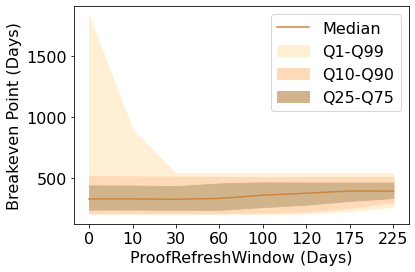

In [ ]:
import seaborn as sns

#colors = {'3':'green', '4':'blue'}
#plt.scatter(breakeven_df['ProofRefreshWindow'], breakeven_df['E[Breakeven Point]'], c = breakeven_df['Number of Refreshes'].map(colors))
# for index,i in breakeven_df.iterrows():

#     label = "{}".format(i['Number of Refreshes'])

#     plt.annotate(label, # this is the text
#                  (i['ProofRefreshWindow'],i['E[Breakeven Point]']), # these are the coordinates to position the label
#                  textcoords="offset pixels", # how to position the text
#                  xytext=(0,5),
#                  ha='right')

# sns.lineplot(x = breakeven_df['ProofRefreshWindow'], y = breakeven_df['0.05'])
# sns.scatterplot(x = 'ProofRefreshWindow', y = '0.05', data=breakeven_df, hue='Number of Refreshes', palette=['green','dodgerblue'], legend='full', s=100)

# breakeven_df.plot(x="ProofRefreshWindow", y=['0.05','0.25','0.5','0.75','0.95'], marker='o')
plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.01'], breakeven_df['0.99'], 
                     alpha=1, color='papayawhip', label='Q1-Q99')
plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.1'], breakeven_df['0.9'], 
                     alpha=1, color='peachpuff', label='Q10-Q90')
# plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.05'], breakeven_df['0.95'], 
#                      alpha=0.55, color='moccasin', label='Q5-Q95')
plt.fill_between(breakeven_df['ProofRefreshWindow'], breakeven_df['0.25'], breakeven_df['0.75'], 
                     alpha=1, color='tan', label='Q25-Q75')
plt.plot(breakeven_df['ProofRefreshWindow'], breakeven_df['0.5'],
                     alpha=1, color='peru', label='Median')
plt.xlabel('ProofRefreshWindow (Days)')
plt.ylabel("Breakeven Point (Days)");
plt.legend()
plt.show()  

Text(0.5, 1.0, '25th Percentile Values')

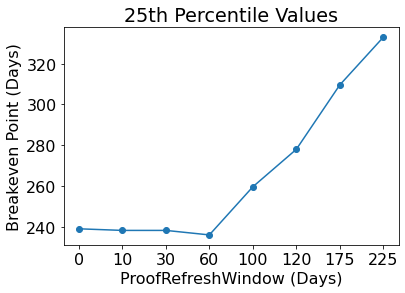

In [ ]:
plt.plot(breakeven_df['ProofRefreshWindow'], breakeven_df['0.25'], alpha=1, marker = 'o')
plt.xlabel('ProofRefreshWindow (Days)')
plt.ylabel("Breakeven Point (Days)");
plt.title('25th Percentile Values')

Text(0.5, 1.0, '50th Percentile Values')

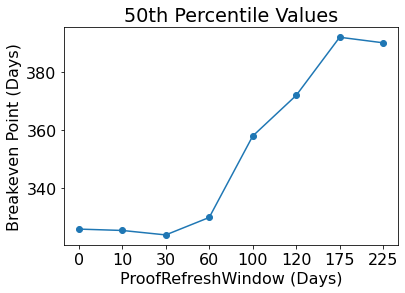

In [ ]:
plt.plot(breakeven_df['ProofRefreshWindow'], breakeven_df['0.5'], alpha=1, marker = 'o')
plt.xlabel('ProofRefreshWindow (Days)')
plt.ylabel("Breakeven Point (Days)");
plt.title('50th Percentile Values')

Text(0.5, 1.0, '75th Percentile Values')

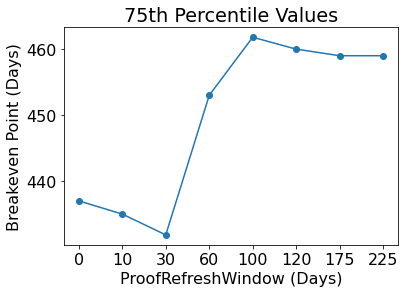

In [ ]:
plt.plot(breakeven_df['ProofRefreshWindow'], breakeven_df['0.75'], alpha=1, marker = 'o')
plt.xlabel('ProofRefreshWindow (Days)')
plt.ylabel("Breakeven Point (Days)");
plt.title('75th Percentile Values')

## Optimal Reseal Time

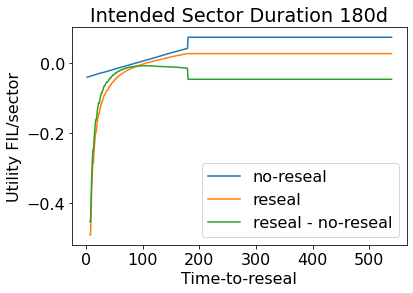

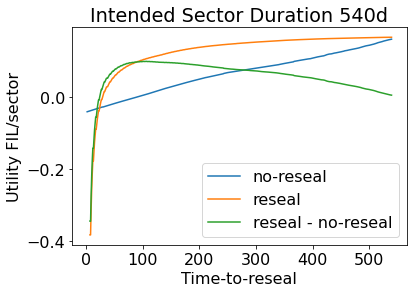

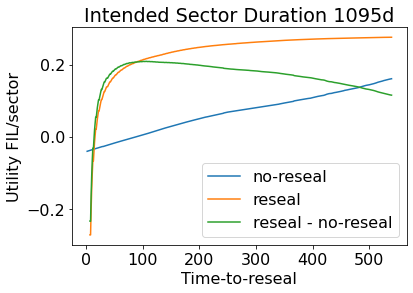

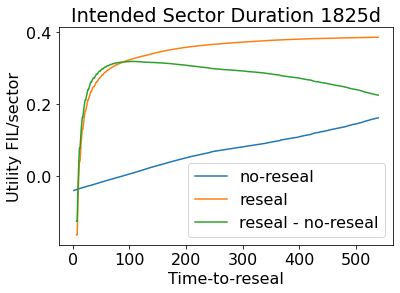

In [ ]:
def plt_1d_utility(strength_gas=0.5,strength_machine=0.5,sector_dur_remaining=100):
    plt.plot(taulist,[u2_noreseal(tau,sector_dur_remaining) for tau in taulist], label='no-reseal');
    plt.plot(taulist,[u1_reseal(tau,sector_dur_remaining,strength_gas,strength_machine) for tau in taulist], label='reseal');
    plt.plot(taulist,[u1_reseal(tau,sector_dur_remaining,strength_gas,strength_machine) - u2_noreseal(tau,sector_dur_remaining) for tau in taulist], 
             label='reseal - no-reseal');
    plt.legend();
    plt.title(f"Intended Sector Duration {sector_dur_remaining}d")
    plt.xlabel('Time-to-reseal')
    plt.ylabel('Utility FIL/sector');
    plt.show()
    
plt_1d_utility(strength_gas=0.5,strength_machine=0.5,sector_dur_remaining=180)
plt_1d_utility(strength_gas=0.5,strength_machine=0.5,sector_dur_remaining=540)
plt_1d_utility(strength_gas=0.5,strength_machine=0.5,sector_dur_remaining=1095)
plt_1d_utility(strength_gas=0.5,strength_machine=0.5,sector_dur_remaining=1825)

In [ ]:
taulist = np.arange(30,540)

# find optimal value of x, to maximise reseal advantage
def find_optimal_reseal_time(lambda_gas:float, lambda_machine:float, T)->float:
    u1_reseals = [u1_reseal(tau, T, lambda_gas, lambda_machine) for tau in taulist]
    u2_noreseals = [u2_noreseal(tau, T) for tau in taulist]
    return taulist[np.argmax(np.array(u1_reseals) - np.array(u2_noreseals))]

for day in [180, 250, 540,1095,1825]:
  print('Optimal reseal time for an intended sector duration of {} days is {} days'.format(day, find_optimal_reseal_time(0.5, 0.5, day)))

Optimal reseal time for an intended sector duration of 180 days is 107 days
Optimal reseal time for an intended sector duration of 250 days is 107 days
Optimal reseal time for an intended sector duration of 540 days is 107 days
Optimal reseal time for an intended sector duration of 1095 days is 107 days
Optimal reseal time for an intended sector duration of 1825 days is 107 days
